## Configurations

In [1]:
import os
import re
import time
import json
import pandas as pd

from dotenv import load_dotenv
from sklearn.metrics.pairwise import cosine_similarity

from typing import List
from pprint import pprint
from typing_extensions import TypedDict
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_ollama import OllamaEmbeddings
from langgraph.graph import END, StateGraph, START
from langchain_community.vectorstores import Chroma
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

from langchain_core.documents import Document
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser

load_dotenv()

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

c:\Users\kevin\anaconda3\envs\torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\kevin\anaconda3\envs\torch\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\kevin\anac

In [2]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

grader_llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    model_kwargs={'response_format': {'type': 'json_object'}}
)

judge_llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [ ]:
pdf_file_path = r"C:\Users\kevin\Documents\Projects\Fraudvestigate\Dataset\Understanding Credit Card Frauds.pdf"

loader = PyPDFLoader(pdf_file_path)
docs = loader.load()

# Chunk the Documents
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, 
    chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs)

embedding_model = OllamaEmbeddings(model="qwen3-embedding:0.6b")

# Embeds the text from PDF and save it to a vectorstore
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="fraud_rag_db",
    embedding=embedding_model, 
)

retriever = vectorstore.as_retriever()
print(f"Indexed: {len(doc_splits)}")

Indexed: 31


## Grader and Generation Chains

In [4]:
# Retrieval Grader (Checks if retrieved documents are relevant to the question)
grader_prompt = PromptTemplate(
    template="""You are a grader assessing the relevance of a retrieved document to a user question. \n 
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.""",
    input_variables=["question", "document"],
)
retrieval_grader = grader_prompt | grader_llm | JsonOutputParser()

# Hallucination Grader (Checks if the answer is based on the documents)
hallucination_prompt = PromptTemplate(
    template="""You are a grader assessing whether an answer is grounded in / supported by a set of facts. \n 
    Here are the facts:
    \n ------- \n
    {documents} 
    \n ------- \n
    Here is the answer: {generation}
    \n
    Give a binary score 'yes' or 'no' score to indicate whether the answer is grounded in / supported by a set of facts. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.""",
    input_variables=["generation", "documents"],
)
hallucination_grader = hallucination_prompt | grader_llm | JsonOutputParser()

# Answer Grader (Checks if the answer actually answers the question)
answer_grader_prompt = PromptTemplate(
    template="""You are a grader assessing whether an answer addresses / resolves a question \n 
    Here is the user question: {question} \n
    Here is the answer: {generation} \n
    Give a binary score 'yes' or 'no' score to indicate whether the answer resolves the question. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.""",
    input_variables=["generation", "question"],
)
answer_grader = answer_grader_prompt | grader_llm | JsonOutputParser()

# Question Re-writer (Necessary for the "transform_query" node in the graph)
rewriter_prompt = PromptTemplate(
    template="""You a question re-writer that converts an input question to a better version that is optimized \n 
    for vectorstore retrieval. Look at the initial and formulate an improved question. \n
    Here is the initial question: {question} \n
    Formulate an improved question with no preamble or explanation.""",
    input_variables=["generation", "question"],
)
question_rewriter = rewriter_prompt | llm | StrOutputParser()

# Generation Chain (Final answer generator)
rag_prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the question. 
    If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise.
    
    IMPORTANT: Provide ONLY the final answer. Do not show your internal thought process, reasoning steps, or <think> tags.
    
    Question: {question} 
    Context: {context} 
    
    Answer:""",
    input_variables=["question", "context"],
)
rag_chain = rag_prompt | llm | StrOutputParser()

## Graph State

In [5]:
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: The user's question.
        generation: The LLM's generated answer.
        documents: A list of retrieved documents.
        retry_count: Number of times we have re-tried the search.
    """
    question : str
    generation : str
    documents : List[Document]
    retry_count: int

## Graph Nodes

In [6]:
def retrieve(state):
    """
    Retrieve documents from the vector store based on the question.
    """
    print("NODE: RETRIEVE")
    question = state["question"]
    documents = retriever.invoke(question)
    
    # Initialize retry_count if it doesn't exist
    retry_count = state.get("retry_count", 0)
    return {"documents": documents, "question": question, "retry_count": retry_count}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.
    """
    print("NODE: GRADE DOCUMENTS")
    question = state["question"]
    documents = state["documents"]
    
    filtered_docs = []
    
    for d in documents:
        score = retrieval_grader.invoke({"question": question, "document": d.page_content})
        grade = score['score']
        if grade.lower() == "yes":
            print("GRADE: DOCUMENT RELEVANT")
            filtered_docs.append(d)
        else:
            print("GRADE: DOCUMENT NOT RELEVANT")
            # If list becomes empty the "decide_to_generate" edge will trigger "transform_query"
            continue
            
    return {"documents": filtered_docs, "question": question}

def transform_query(state):
    """
    Transform the query to produce a better question.
    """
    print("NODE: TRANSFORM QUERY")
    question = state["question"]
    documents = state["documents"]
    retry_count = state.get("retry_count", 0)
    
    # Rewrite question
    better_question = question_rewriter.invoke({"question": question})
    print(f"TRANSFORMED QUESTION: {better_question}")
    
    # Increment the retry counter
    return {
        "documents": documents, 
        "question": better_question, 
        "retry_count": retry_count + 1 
    }

def generate(state):
    """
    Generate an answer using the retrieved documents.
    """
    print("NODE: GENERATE")
    question = state["question"]
    documents = state["documents"]
    
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers the question.
    This function is used in the conditional edge.
    """
    print("CHECK HALLUCINATIONS")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    
    score = hallucination_grader.invoke({"documents": documents, "generation": generation})
    grade = score['score']
    
    if grade == "yes":
        print("DECISION: GENERATION IS GROUNDED IN DOCUMENTS")
        # Check answer-relevance
        print("CHECK ANSWER RELEVANCE")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score['score']
        
        if grade == "yes":
            print("DECISION: GENERATION ADDRESSES QUESTION")
            return "useful"
        else:
            print("DECISION: GENERATION DOES NOT ADDRESS QUESTION")
            return "not useful"
    else:
        print("DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY")
        return "not supported"

## Graph Conditional Edges

In [7]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.
    """
    print("ASSESS GRADED DOCUMENTS")
    filtered_documents = state["documents"]
    retry_count = state.get("retry_count", 0)

    # CIRCUIT BREAKER: If we have retried 3 times, force generation to stop the loop
    if retry_count >= 3:
        print("DECISION: MAX RETRIES REACHED. FORCING GENERATION.")
        return "generate"

    if not filtered_documents:
        # All documents have been filtered check_relevance -> regenerate a new query
        print("DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY")
        return "transform_query"

    # Relevant documents -> generate answer
    print("DECISION: GENERATE")
    return "generate"

def grade_generation_v_documents_and_question(state):
    """
    Determines if the generation is grounded and useful.
    Routes to re-generation, query transformation, or finishes the process.
    """
    print("EDGE: GRADE GENERATION")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    retry_count = state.get("retry_count", 0)

    # CIRCUIT BREAKER: If max retries reached, accept the answer even if imperfect
    # This prevents the "Hallucination -> Rewrite -> Retrieve" infinite loop
    if retry_count >= 3:
        print("DECISION: MAX RETRIES. STOPPING GRADING.")
        return "useful"

    # Hallucination check
    score = hallucination_grader.invoke({"documents": documents, "generation": generation})
    grade = score['score']

    if grade == "no":
        print("DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY")
        return "not supported"

    # Answer usefulness check
    score = answer_grader.invoke({"question": question, "generation": generation})
    grade = score['score']

    if grade == "no":
        print("DECISION: GENERATION DOES NOT ADDRESS QUESTION, TRANSFORM QUERY")
        return "not useful"
    
    print("DECISION: GENERATION IS USEFUL, FINISHING")
    return "useful"

## Build and Viz

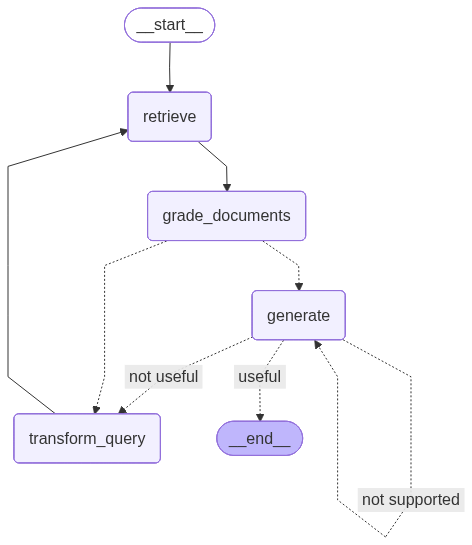

In [8]:
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)                # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)                # generate
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")

workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",          # Loop back to rewrite if retrieval failed
        "generate": "generate",                        # Move to generate if retrieval worked
    },
)

workflow.add_edge("transform_query", "retrieve")

workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",                   # Hallucination: Retry generation
        "useful": END,                                 # Good answer: End
        "not useful": "transform_query",               # Grounded but irrelevant: Rewrite query
    },
)

app = workflow.compile()

display(Image(app.get_graph().draw_mermaid_png()))

## Sample Test

In [9]:
inputs = {"question": "What are some techniques used for creating false and counterfeit cards?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")

print("\nFINAL ANSWER")
print(value["generation"])

NODE: RETRIEVE
'Finished running: retrieve:'
NODE: GRADE DOCUMENTS
GRADE: DOCUMENT RELEVANT
GRADE: DOCUMENT RELEVANT
GRADE: DOCUMENT RELEVANT
GRADE: DOCUMENT RELEVANT
ASSESS GRADED DOCUMENTS
DECISION: GENERATE
'Finished running: grade_documents:'
NODE: GENERATE
EDGE: GRADE GENERATION
DECISION: GENERATION IS USEFUL, FINISHING
'Finished running: generate:'

FINAL ANSWER
Some techniques used for creating false and counterfeit cards include erasing the magnetic strip of an existing card, creating a fake card from scratch using sophisticated machines, altering card details through re-embossing or re-encoding, skimming genuine card data, and using white plastic cards encoded with legitimate magnetic stripe data.


In [10]:
questions = [
    # Broad Text Question (Should work if PDF is loaded)
    "What are the main methods used to commit credit card fraud according to the document?",

    # Specific Fact Question (Tests retrieval accuracy)
    "Does the document mention specific operational costs or losses related to fraud?",

    # The "Chart" Question (If it fails, it confirms the PDF loader couldn't read the image/graph)
    "Which credit card type has a higher percentage of 'Stolen' fraud cases?"
]

for q in questions:
    print(f"QUESTION: {q}")
    inputs = {"question": q}
    
    # Retrieve -> Grade -> Generate
    for output in app.stream(inputs):
        for key, value in output.items():
            print(f"Finished running: {key}")
            
            # If the generation node finished, print the answer
            if key == "generate":
                print("\nGENERATED ANSWER")
                print(value["generation"])
                
    print("\nEND OF QUESTION CYCLE")

QUESTION: What are the main methods used to commit credit card fraud according to the document?
NODE: RETRIEVE
Finished running: retrieve
NODE: GRADE DOCUMENTS
GRADE: DOCUMENT RELEVANT
GRADE: DOCUMENT RELEVANT
GRADE: DOCUMENT RELEVANT
GRADE: DOCUMENT RELEVANT
ASSESS GRADED DOCUMENTS
DECISION: GENERATE
Finished running: grade_documents
NODE: GENERATE
EDGE: GRADE GENERATION
DECISION: GENERATION IS USEFUL, FINISHING
Finished running: generate

GENERATED ANSWER
The main methods used to commit credit card fraud include unauthorized use of account information, skimming, and altering card details. Fraudsters may also create counterfeit cards or use white plastic cards encoded with legitimate data for illegal transactions. Additionally, internet-related frauds are increasingly common due to the lack of physical verification.

END OF QUESTION CYCLE
QUESTION: Does the document mention specific operational costs or losses related to fraud?
NODE: RETRIEVE
Finished running: retrieve
NODE: GRADE DOC

## Evaluation

In [11]:
def rag_judge_score(question, answer, context_docs):
    """
    Evaluates RAG Answer on two criteria:
    1. Relevance: Does it answer the user's question?
    2. Faithfulness: Is it supported by the retrieved context?
    """
    # Combine context content for the judge to read
    context_text = "\n\n".join([doc.page_content[:500] for doc in context_docs])
    
    judge_prompt = f"""
    Act as an impartial judge for a RAG (Retrieval Augmented Generation) system.
    
    User Question: {question}
    Retrieved Context: {context_text}
    Generated Answer: {answer}
    
    Evaluate on a scale of 1-10 based on:
    - Faithfulness: Is the answer derived ONLY from the context? (No hallucinations)
    - Relevance: Does the answer directly address the question?
    
    Return JSON ONLY: {{"score": <number>}}
    """
    try:
        response = judge_llm.invoke(judge_prompt).content
        start = response.find("{")
        end = response.rfind("}") + 1
        data = json.loads(response[start:end])
        return data.get("score", 0)
    except Exception as e:
        print(f"Judge Error: {e}")
        return 0

In [12]:
def calculate_similarity(text1, text2):
    if not text1 or not text2: return 0.0
    vec1 = embedding_model.embed_query(text1)
    vec2 = embedding_model.embed_query(text2)
    return cosine_similarity([vec1], [vec2])[0][0]

In [13]:
def run_rag_evaluation(test_questions):
    results = []
    print(f"RAG Evaluation on {len(test_questions)} questions...\n")
    
    for i, q in enumerate(test_questions):
        print(f"Evaluating Q{i+1}: {q}...")
        start_time = time.time()
        
        try:
            # GRAPH EXECUTION
            inputs = {"question": q}
            final_state = app.invoke(inputs)
            
            final_answer = final_state.get("generation", "No Answer Generated")
            retrieved_docs = final_state.get("documents", [])
            
            end_time = time.time()
            latency = end_time - start_time
            
            # Success (Did we get an answer?)
            success = 1 if final_answer and "I don't know" not in final_answer and "recursion" not in final_answer.lower() else 0
            
            # Similarity
            sim_score = calculate_similarity(q, final_answer)
            
            # Judge Score
            quality_score = rag_judge_score(q, final_answer, retrieved_docs)
            
            results.append({
                "Question": q,
                "Latency (s)": round(latency, 2),
                "Success": success,
                "Semantic Sim": round(sim_score, 2),
                "Judge Score": quality_score,
                "Context Count": len(retrieved_docs),
                "Answer Snippet": final_answer[:100] + "..."
            })
            
        except Exception as e:
            print(f"Failed on Q{i+1}: {e}")
            results.append({"Question": q, "Success": 0, "Error": str(e)})

    return pd.DataFrame(results)

In [14]:
rag_test_set = [
    # Techniques ("Fraud Techniques" section)
    "What are some techniques used for creating false and counterfeit cards?",
    
    # Methodology ("How Fraud is Committed" - 48% Lost/Stolen)
    "What are the primary methods by which credit card fraud is committed?",
    
    # Impact ("Impact on Cardholders" - limited liability)
    "What is the impact of fraud on cardholders?",
    
    # Specific Stats ("Current State" - $2.5B losses)
    "Does the document mention specific operational costs or losses in 2002?",
    
    # System Design ("Fraud Prevention" - Neural Networks/AVS)
    "What are the core components of an effective fraud prevention system?",
    
    # Specific Country Stat ("High-risk countries" - Indonesia 18.3%)***
    "Which countries are listed as having the highest rates of fraud?",

    # Comparison ("Internet fraud is 15x higher")
    "How does the fraud risk compare between internet transactions and face-to-face transactions?",

    # Tech Specifics ("Neural network technologies")
    "How are neural networks used in fraud detection?",

    # Prevention ("Manual review, AVS, CVM")
    "What specific technologies are mentioned for preventing fraud?",

    # Negative Test (Hallucination Check)
    "What does the document say about cryptocurrency or Bitcoin fraud?" 
]

In [15]:
df_rag_results = run_rag_evaluation(rag_test_set)

print("RAG EVALUATION REPORT")
print(f"Success Rate:    {df_rag_results['Success'].mean():.0%}")
print(f"Avg Latency:     {df_rag_results['Latency (s)'].mean():.2f}s")
print(f"Avg Judge Score: {df_rag_results['Judge Score'].mean():.1f}/10")
print(f"Avg Similarity:  {df_rag_results['Semantic Sim'].mean():.2f}")

df_rag_results

RAG Evaluation on 10 questions...

Evaluating Q1: What are some techniques used for creating false and counterfeit cards?...
NODE: RETRIEVE
NODE: GRADE DOCUMENTS
GRADE: DOCUMENT RELEVANT
GRADE: DOCUMENT RELEVANT
GRADE: DOCUMENT RELEVANT
GRADE: DOCUMENT RELEVANT
ASSESS GRADED DOCUMENTS
DECISION: GENERATE
NODE: GENERATE
EDGE: GRADE GENERATION
DECISION: GENERATION IS USEFUL, FINISHING
Evaluating Q2: What are the primary methods by which credit card fraud is committed?...
NODE: RETRIEVE
NODE: GRADE DOCUMENTS
GRADE: DOCUMENT RELEVANT
GRADE: DOCUMENT RELEVANT
GRADE: DOCUMENT RELEVANT
GRADE: DOCUMENT RELEVANT
ASSESS GRADED DOCUMENTS
DECISION: GENERATE
NODE: GENERATE
EDGE: GRADE GENERATION
DECISION: GENERATION IS USEFUL, FINISHING
Evaluating Q3: What is the impact of fraud on cardholders?...
NODE: RETRIEVE
NODE: GRADE DOCUMENTS
GRADE: DOCUMENT RELEVANT
GRADE: DOCUMENT RELEVANT
GRADE: DOCUMENT NOT RELEVANT
GRADE: DOCUMENT RELEVANT
ASSESS GRADED DOCUMENTS
DECISION: GENERATE
NODE: GENERATE
EDGE: 

,Question,Latency (s),Success,Semantic Sim,Judge Score,Context Count,Answer Snippet
0,What are some techniques used for creating fal...,8.38,1,0.84,8,4,Some techniques used for creating false and co...
1,What are the primary methods by which credit c...,7.10,1,0.78,6,4,Credit card fraud is primarily committed throu...
2,What is the impact of fraud on cardholders?,6.48,1,0.66,3,3,The impact of fraud on cardholders is generall...
3,Does the document mention specific operational...,5.76,1,0.58,9,1,"Yes, the document mentions that the losses due..."
4,What are the core components of an effective f...,5.91,1,0.68,4,2,The core components of an effective fraud prev...
5,Which countries are listed as having the highe...,5.68,1,0.89,8,2,The countries listed as having the highest rat...
6,How does the fraud risk compare between intern...,7.24,1,0.82,9,3,The fraud risk for internet transactions is si...
7,How are neural networks used in fraud detection?,8.05,1,0.73,8,4,Neural networks are used in fraud detection by...
8,What specific technologies are mentioned for p...,6.12,1,0.87,3,2,The specific technologies mentioned for preven...
9,What does the document say about cryptocurrenc...,16.09,0,0.43,5,0,I don't know....
